### Import Automotive Data and Cleanse

Machine Learning for Engineers: [Automotive Monitoring](https://www.apmonitor.com/pds/index.php/Main/AutomotiveMonitoring)
- Description: Machine learning project with automotive data. Data includes travel distance, time, fuel rate, air flow, oxygen ratio, and other parameters available from an OBD2 interface.
- [Course Overview](https://apmonitor.com/pds)
- [Course Schedule](https://apmonitor.com/pds/index.php/Main/CourseSchedule)

<img width=400px align=left src='https://apmonitor.com/pds/uploads/Main/automotive_monitoring.png'>

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Data and View Columns

Import `auto_warmup.csv`, set time index, and print data columns

In [2]:
url = 'http://apmonitor.com/pds/uploads/Main/auto_warmup.txt'
data = pd.read_csv(url)

# set time index
data['time'] = pd.to_datetime(data['time'])
data = data.set_index('time')

# print data columns
for x in data.columns:
    print(x)

# warm-ups since codes cleared ()
A/C pressure (kPa)
Absolute load value (%)
Absolute pedal position D (%)
Absolute pedal position E (%)
Absolute throttle position B (%)
Air:fuel ratio ()
Ambient air temperature (℉)
Average fuel consumption (MPG)
Average fuel consumption (total) (MPG)
Average fuel consumption 10 sec (MPG)
Average speed (mph)
Barometric pressure (kPa)
Calculated boost (bar)
Calculated engine load value (%)
Calculated instant fuel consumption (MPG)
Calculated instant fuel rate (gal./h)
Catalyst temperature Bank 1 Sensor 1 (℉)
Commanded evaporative purge (%)
Commanded throttle actuator (%)
Control module voltage (V)
Distance traveled since codes cleared (miles)
Distance traveled with MIL on (miles)
Distance travelled (miles)
Distance travelled (total) (miles)
Engine coolant temperature (℉)
Engine RPM (rpm)
Ethanol fuel percent (%)
Evap. system vapor pressure (Pa)
Fuel economizer (based on fuel system status and throttle position) ()
Fuel level input (%) (%)
Fuel level inp

### Select Columns of Interest

In [3]:
# select columns of interest
data1 = data[['Engine coolant temperature (℉)']].copy()
data1.dropna(inplace=True)
data2 = data[['Catalyst temperature Bank 1 Sensor 1 (℉)']].copy()
data2.dropna(inplace=True)
data3 = data[['Vehicle speed (mph)']].copy()

# join data
data = data1.join(data2,how='outer',sort=True)
data = data.join(data3,how='outer',sort=True)
data.columns = ['coolant (degF)','catalyst (degF)','speed (mph)']
data.head()
    
# fill in NaNs - forward fill
data.fillna(method='ffill',inplace=True)
# fill in NaNs - backward fill
data.fillna(method='bfill',inplace=True)
dr = len(data)
data.describe()

,coolant (degF),catalyst (degF),speed (mph)
count,13316.000000,13316.000000,13316.000000
mean,159.030309,812.612094,0.865141
std,44.399522,177.670751,3.272165
min,-7.600000,46.940000,0.000000
25%,131.000000,780.080000,0.000000
50%,172.400000,799.520000,0.000000
75%,199.400000,817.520000,0.000000
max,204.800000,1252.220000,42.253241


### Plot Data

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

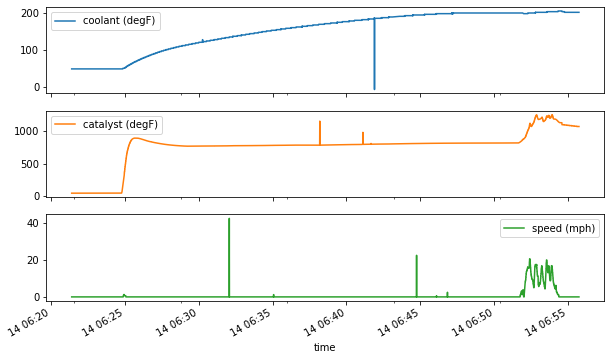

In [4]:
data.plot(subplots=True,figsize=(10,6))

### Remove Gross Outliers

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

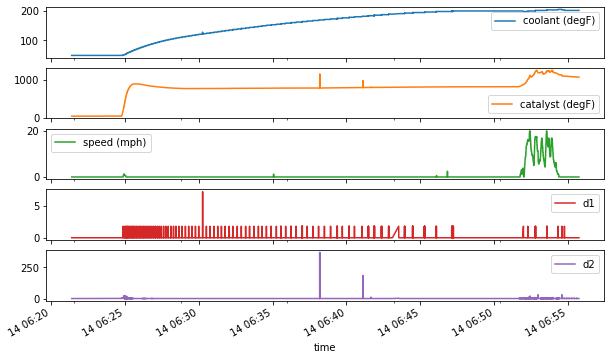

In [5]:
# data cleansing
data = data[data['coolant (degF)']>40]
data = data[data['speed (mph)']<20]

data['d1'] = data['coolant (degF)'].diff().abs()
data['d2'] = data['catalyst (degF)'].diff().abs()
data.plot(subplots=True,figsize=(10,6))

### Remove Other Outliers and Bad Speed Data

Rows removed:  107  of  13316


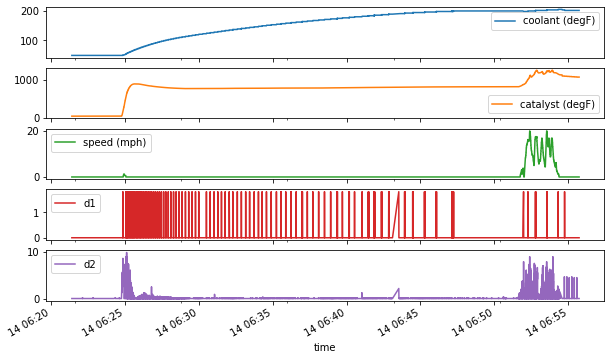

In [6]:
# 3 cycles because cat temperature stays high for a few samples
for i in range(3):
    data['d1'] = data['coolant (degF)'].diff().abs()
    data['d2'] = data['catalyst (degF)'].diff().abs()
    data = data[data['d1']<5]
    data = data[data['d2']<10]

# zero speed between 6:30 to 6:50
data.iloc[data.index.indexer_between_time('06:30','06:50'), 2] = 0

data.plot(subplots=True,figsize=(10,6))
print('Rows removed: ',dr-len(data), ' of ', dr)

### Insert Feature (Engine On/Off) and Reduce Data

In [7]:
# delete d1 and d2
del data['d1']
del data['d2']

# add engine state (on/off)
data['engine'] = 0
data.iloc[data.index.indexer_between_time('06:24:46','06:55:01'), 3] = 1

### Display Cleansed Data

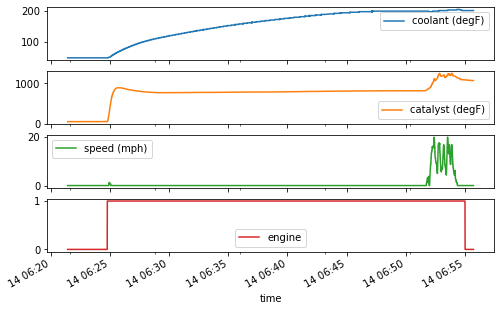

In [8]:
data.plot(subplots=True,figsize=(8,5))
plt.savefig('auto_warmup.png',dpi=300)
data.to_csv('auto_clean.csv')

### Determine Time to Catalyst Light-off

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

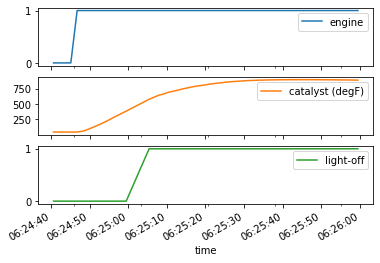

In [12]:
select = ['engine','catalyst (degF)']
s = data[select].between_time('06:24:40','06:26:00').copy()
s['light-off'] = (s['catalyst (degF)']>500).astype(int)
s.plot(subplots=True)

In [19]:
# find engine start time
for i in range(1,len(s)):
    if s['engine'].iloc[i]==1:
        engine_start = s.index[i]
        break

# find light-off time
for i in range(1,len(s)):
    if s['light-off'].iloc[i]==1:
        lightoff_start = s.index[i]
        break

# calculate seconds to catalyst light-off
dt = lightoff_start - engine_start
print(dt.total_seconds(), 'sec to catalyst light-off')        

18.641 sec to catalyst light-off


### Create ARX Model

In [10]:
# reduce data to about every 1-2 sec
data = data[::10].copy()

data['tmin'] = data.index
t0 = data['tmin'].iloc[0]
dt = (data['tmin'].copy()-t0)
dt2 = []
for i in range(len(data)):
    dt2.append(dt[i].total_seconds()/60.0)
data['tmin'] = dt2

No handles with labels found to put in legend.


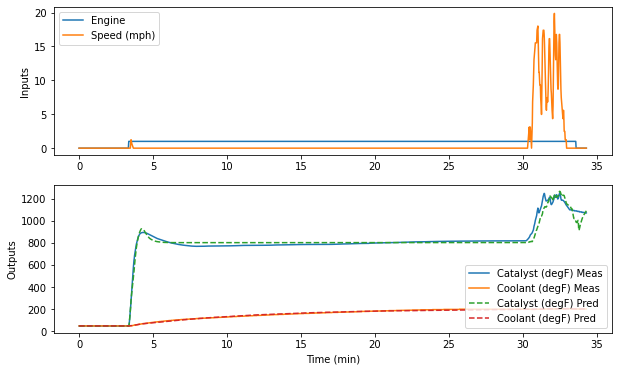

In [11]:
from gekko import GEKKO

t = data['tmin'].values
u = data[['engine','speed (mph)']]
y = data[['catalyst (degF)','coolant (degF)']]

# generate time-series model
m = GEKKO(remote=False)

# system identification
na = 2 # output coefficients
nb = 40 # input coefficients
yp,p,K = m.sysid(t,u,y,na,nb,pred='meas')

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend(['Engine','Speed (mph)'],loc=2)
plt.ylabel('Inputs')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp,'--')
plt.legend(); plt.ylabel('Outputs')
plt.legend(['Catalyst (degF) Meas','Coolant (degF) Meas',\
            'Catalyst (degF) Pred','Coolant (degF) Pred'],loc=4)

plt.xlabel('Time (min)'); plt.savefig('sysid.png')
plt.show()